**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).**

**2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.**

In [150]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [151]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=2)

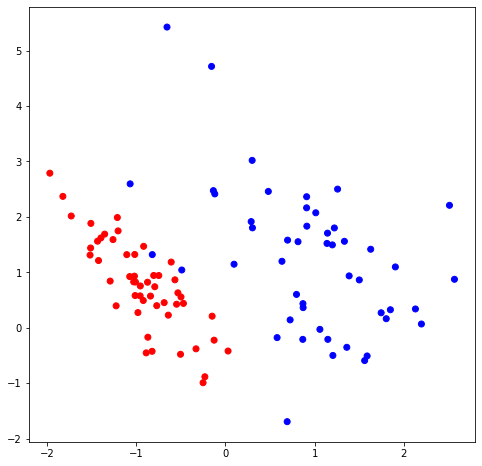

In [152]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [153]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  
        self.t = t  
        self.true_branch = true_branch 
        self.false_branch = false_branch  

In [154]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1   
        prediction = max(classes, key=classes.get)
        return prediction        

Добавим возможность обучить дерево решений с использованием критериев разбиения Джини и Энтропии на выбор. 
P.S. Python ругался на impurity, говоря, что я ее использую раньше чем объявляю. Пришлось добавить **global impurity**. Но не уверен, что алгоритм работает правильно, в конце ноутбкука я вызываю функцию построения модели с критерием 'entropy', но метрика не изменилась. 

In [197]:
def inf_criterion(labels, crit):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        
    global impurity
    
    if crit == 'gini':
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
            
    if crit == 'entropy':
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity += p*np.log2(p)
            
    return impurity if crit == 'gini' else -impurity

In [198]:
def quality(left_labels, right_labels, current_gini, crit):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * inf_criterion(left_labels, crit) - (1 - p) * inf_criterion(right_labels,crit)

In [199]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [200]:
def find_best_split(data, labels, crit):
    
    min_leaf = 5

    current_gini = inf_criterion(labels, crit)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):

        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini, crit)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Добавим в функцию build_tree проверку по количеству листьев и глубине дерева, для останова рекурсии.

In [201]:
def build_tree(data, labels, crit, current_depth = 0, max_depth = 0, current_leaves = 0, max_leaves = 0):

    quality, t, index = find_best_split(data, labels, crit)

    if quality == 0:
        return Leaf(data, labels)
    
    if max_depth != 0 and current_depth == max_depth:
        return Leaf(data, labels)
    
    if max_leaves != 0 and current_leaves == max_leaves:
        return Leaf(data, labels)   
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    current_leaves = current_leaves + 2
    current_depth = current_depth + 1
    
    true_branch = build_tree(true_data, true_labels, current_depth, max_depth, current_leaves, max_leaves)
    false_branch = build_tree(false_data, false_labels, current_depth, max_depth, current_leaves, max_leaves)

    return Node(index, t, true_branch, false_branch)

In [202]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [203]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [204]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 2)

Вызовем функцию my_tree с агрументами - кол-во листьев и глубина дерева. А также выберем критерий разбиения.

In [205]:
my_tree = build_tree(train_data, train_labels, crit ='gini', max_depth = 4, max_leaves = 16)

In [206]:
train_answers = predict(train_data, my_tree)

In [207]:
answers = predict(test_data, my_tree)

In [208]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [209]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [210]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.33333333333333

Text(0.5, 1.0, 'Test accuracy=93.33')

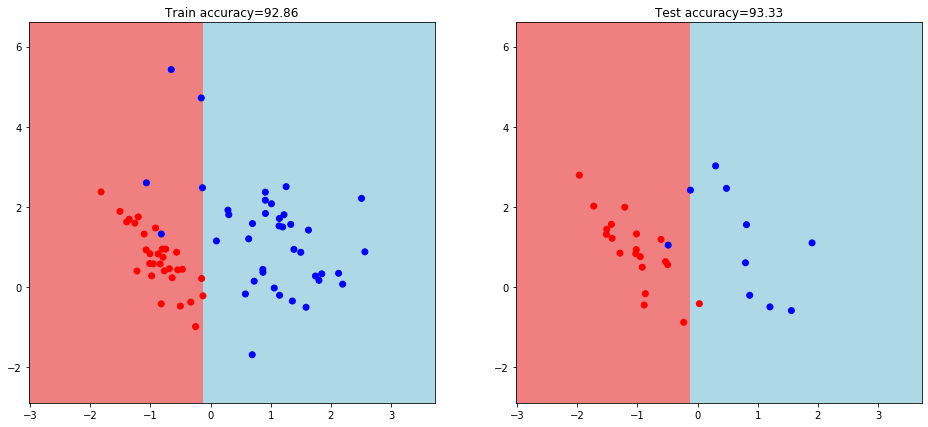

In [211]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [212]:
my_tree = build_tree(train_data, train_labels, crit ='entropy', max_depth = 4, max_leaves = 16)

In [213]:
train_answers = predict(train_data, my_tree)

In [214]:
answers = predict(test_data, my_tree)

In [215]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [216]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.33333333333333